In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from wbfm.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from pathlib import Path
from collections import defaultdict
import zarr

/home/charles/anaconda3/envs/wbfm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [96]:

def df_from_list(list_of_annotations, col_name_base):
    all_vals = defaultdict(list)
    for proj in list_of_annotations:
        for k, v in proj.items():
            if isinstance(v, list):
                all_vals[k].append(len(v))
                
    all_vals['title'] = [col_name_base] * len(list_of_annotations)

    idx_names = [f'{col_name_base}_{i}' for i in range(len(list_of_annotations))]
    df = pd.DataFrame(all_vals, index=idx_names)
    
    return df

# Loading all projects

## Original, low laser power

In [2]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm1/project_config.yaml"
project_data1 = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm1/dat/2022-01-27_19-31_worm1_Ch0bigtiff.btf_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm1/dat/2022-01-27_19-31_worm1_Ch1bigtiff.btf_preprocessed.zarr.zip on os posix...


File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm1/3-tracking/postprocessing/combined_3d_tracks---9.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220127/data/worm1/2022-01-27_19-31_worm1_Ch0/2022-01-27_19-31_worm1_Ch0bigtiff.btf on os posix...
Annotations are already stable style
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220127/data/worm1/2022-01-27_19-31-00_worm1-channel-0-behaviour-/skeleton_spline_K.csv on os posix...
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220127/data/worm1/2022-01-27_19-31-00_worm1-channel-0-behaviour-/skeleton_spline_X_coords.csv on os posix...
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220127/data/worm1/2022-01-27_19-31-00_worm1-channel-0-behaviour-/skeleton_spline_Y_coords.csv on os posix...
Con

In [3]:
# Same project, but remote = most updated
# fname = "/home/charles/dlc_stacks/students-worm4-reanalysis/project_config-workstation.yaml"
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm4/project_config.yaml"
project_data2 = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm4/dat/2022-01-27_21-26_worm4_Ch0bigtiff.btf_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm4/dat/2022-01-27_21-26_worm4_Ch1bigtiff.btf_preprocessed.zarr.zip on os posix...
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm4/3-tracking/postprocessing/combined_3d_tracks-3.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220127/data/worm4/2022-01-27_21-26_worm4_Ch0/2022-01-27_21-26_worm4_Ch0bigtiff.btf on os posix...
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220127/data/worm4/2022-01-27_21-26-53_worm4-channel-0-behaviour-/skelet

In [4]:
# # Partial... still uint8
# fname = "/home/charles/dlc_stacks/round2-worm6-short-newseg/project_config-workstation.yaml"
# project_data3 = ProjectData.load_final_project_data_from_config(fname, to_load_frames=True)

In [5]:
# REMOTE
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/project_config.yaml"
project_data4 = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/dat/2022-02-23_17-22_worm3_1_Ch0bigtiff_preprocessed.zarr.zip on os posix...
Did not successfully resolve path; returning raw /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/dat/2022-02-23_17-22_worm3_1_Ch0bigtiff_preprocessed.zarr.zip
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/dat/2022-02-23_17-22_worm3_1_Ch1bigtiff_preprocessed.zarr.zip on os posix...
Did not successfully resolve path; returning raw /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/dat/2022-02-23_17-22_worm3_1_Ch1bigtiff_preprocessed.zarr.zip
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/3-tracking/postprocessing/combined_3d_tracks-11.h5
ConfigFile  : INFO 

ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220223/data/worm3/2022-02-23_17-22_worm3_1_Ch0/2022-02-23_17-22_worm3_1_Ch0bigtiff.btf on os posix...
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220223/data/worm3/2022-02-23_17-22-34_worm3_1-channel-0-behaviour-/skeleton_spline_K.csv on os posix...
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220223/data/worm3/2022-02-23_17-22-34_worm3_1-channel-0-behaviour-/skeleton_spline_X_coords.csv on os posix...
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220223/data/worm3/2022-02-23_17-22-34_worm3_1-channel-0-behaviour-/skeleton_spline_Y_coords.csv on os posix...
ConfigFile  : INFO     Read all data from files: ['/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/3-tracking/postprocessing/combined_3d_tracks-11.h5', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/dat/2022-02-23_17-22

## GFP

In [6]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/gfp_ZIM2319_worm5/project_config.yaml"
project_data_gfp1 = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/gfp_ZIM2319_worm5/dat/2022-04-09_14-51_ZIM2319_worm5_Ch0bigtiff_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/gfp_ZIM2319_worm5/dat/2022-04-09_14-51_ZIM2319_worm5_Ch1bigtiff_preprocessed.zarr.zip on os posix...
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/gfp_ZIM2319_worm5/3-tracking/postprocessing/combined_3d_tracks-4.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220409/data/ZIM2319_worm5/2022-04-09_14-51_ZIM2319_worm5_Ch0/2022-04-09_14-51_ZIM2319_worm5_Ch0bigtiff.btf on os posix...
ConfigFile  : WARNING  Project does not have a behavior config file
ConfigFile  :

## Bright worms (old)

In [8]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/bright_worm5/project_config.yaml"
project_data_bright1 = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/bright_worm5/dat/2021-12-17_16-28-19_worm5-channel-0-pco_camera1bigtiff_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/bright_worm5/dat/2021-12-17_16-28-19_worm5-channel-1-pco_camera2bigtiff_preprocessed.zarr.zip on os posix...


File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/bright_worm5/3-tracking/postprocessing/combined_3d_tracks-1.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20211217/data/worm5/2021-12-17_16-28-19_worm5-channel-0-pco_camera1/2021-12-17_16-28-19_worm5-channel-0-pco_camera1bigtiff.btf on os posix...
ConfigFile  : WARNING  Did not find at least one centerline related file: [None, None, None]
Annotations are already stable style
ConfigFile  : INFO     Read all data from files: ['/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/bright_worm5/3-tracking/postprocessing/combined_3d_tracks-1.h5', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/bright_worm5/dat/2021-12-17_16-28-19_worm5-channel-0-pco_camera1bigtiff_preprocessed.zarr.zip', '/scratch/neur

In [19]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/bright_worm7/project_config.yaml"
project_data_bright2 = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/bright_worm7/dat/2021-12-17_17-38-56_worm7-channel-0-pco_camera1bigtiff_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/bright_worm7/dat/2021-12-17_17-38-56_worm7-channel-1-pco_camera2bigtiff_preprocessed.zarr.zip on os posix...
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/bright_worm7/3-tracking/postprocessing/combined_3d_tracks-1.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20211217/data/worm7/2021-12-17_17-38-56_worm7-channel-0-pco_camera1/2021-12-17_17-38-56_worm7-channel-0-pco_camera1bigtiff.btf on os posix...
ConfigFile  : WARNING  Did not find at least one cen

ConfigFile  : INFO     =======================================
Project data for directory:
/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/bright_worm7 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
manual_tracking:          False
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



## Bright worms (new)

In [15]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright6-2022_07_12/project_config.yaml"
project_data1_C = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright6-2022_07_12/dat/2022-06-14_14-04_ZIM2156_worm6_Ch0bigtiff_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright6-2022_07_12/dat/2022-06-14_14-04_ZIM2156_worm6_Ch1bigtiff_preprocessed.zarr.zip on os posix...
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright6-2022_07_12/3-tracking/postprocessing/combined_3d_tracks.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220614/data/ZIM2156_worm6/2022-06-14_14-04_ZIM2156_worm6_Ch0/2022-06-14_14-04_ZIM2156_worm6_Ch0bigtiff.btf on os posix...
Found no behavior subfolder in /scratch/neurobiology/zimmer/ulises/wbfm/20220614/data/ZIM

ConfigFile  : INFO     =======================================
Project data for directory:
/scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright6-2022_07_12 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
manual_tracking:          False
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



In [16]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright7-2022_06_30/project_config.yaml"

project_data2_C = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright7-2022_06_30/dat/2022-06-14_14-23_ZIM2156_worm7_Ch0bigtiff_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright7-2022_06_30/dat/2022-06-14_14-23_ZIM2156_worm7_Ch1bigtiff_preprocessed.zarr.zip on os posix...
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright7-2022_06_30/3-tracking/postprocessing/combined_3d_tracks.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220614/data/ZIM2156_worm7/2022-06-14_14-23_ZIM2156_worm7_Ch0/2022-06-14_14-23_ZIM2156_worm7_Ch0bigtiff.btf on os posix...
Found no behavior subfolder in /scratch/neurobiology/zimmer/ulises/wbfm/20220614/data/ZIM

ConfigFile  : INFO     =======================================
Project data for directory:
/scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright7-2022_06_30 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
manual_tracking:          False
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



In [17]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright8-2022_06_30/project_config.yaml"
project_data3_C = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright8-2022_06_30/dat/2022-06-14_14-41_ZIM2156_worm8_Ch0bigtiff_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright8-2022_06_30/dat/2022-06-14_14-41_ZIM2156_worm8_Ch1bigtiff_preprocessed.zarr.zip on os posix...
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright8-2022_06_30/3-tracking/postprocessing/combined_3d_tracks.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220614/data/ZIM2156_worm8/2022-06-14_14-41_ZIM2156_worm8_Ch0/2022-06-14_14-41_ZIM2156_worm8_Ch0bigtiff.btf on os posix...
Found no behavior subfolder in /scratch/neurobiology/zimmer/ulises/wbfm/20220614/data/ZIM

ConfigFile  : INFO     =======================================
Project data for directory:
/scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright8-2022_06_30 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
manual_tracking:          False
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



In [18]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright9-2022_06_30/project_config.yaml"
project_data4_C = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright9-2022_06_30/dat/2022-06-14_15-04_ZIM2156_worm9_Ch0bigtiff_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright9-2022_06_30/dat/2022-06-14_15-04_ZIM2156_worm9_Ch1bigtiff_preprocessed.zarr.zip on os posix...
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright9-2022_06_30/3-tracking/postprocessing/combined_3d_tracks.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220614/data/ZIM2156_worm9/2022-06-14_15-04_ZIM2156_worm9_Ch0/2022-06-14_15-04_ZIM2156_worm9_Ch0bigtiff.btf on os posix...
Found no behavior subfolder in /scratch/neurobiology/zimmer/ulises/wbfm/20220614/data/ZIM

ConfigFile  : INFO     =======================================
Project data for directory:
/scratch/neurobiology/zimmer/Charles/dlc_stacks/incomplete/C-NewBright9-2022_06_30 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
manual_tracking:          False
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



## 12ms exposure (and bright)

In [9]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm3-2022_08_01/project_config.yaml"
project_data1_12ms = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm3-2022_08_01/dat/2022-07-29_12-25_ZIM2156_worm3good_Ch0bigtiff_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm3-2022_08_01/dat/2022-07-29_12-25_ZIM2156_worm3good_Ch1bigtiff_preprocessed.zarr.zip on os posix...
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm3-2022_08_01/3-tracking/postprocessing/combined_3d_tracks.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220729/20220729_12ms/data/ZIM2156_worm3/2022-07-29_12-25_ZIM2156_worm3good_Ch0/2022-07-29_12-25_ZIM2156_worm3good_Ch0bigtiff.btf on os posix...
Found no behavior subfolder in /scratch/neurobi

ConfigFile  : INFO     =======================================
Project data for directory:
/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm3-2022_08_01 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
manual_tracking:          False
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



In [10]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm6-2022_08_01/project_config.yaml"
project_data2_12ms = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm6-2022_08_01/dat/2022-07-29_15-25_ZIM2156_worm6_Ch0bigtiff_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm6-2022_08_01/dat/2022-07-29_15-25_ZIM2156_worm6_Ch1bigtiff_preprocessed.zarr.zip on os posix...
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm6-2022_08_01/3-tracking/postprocessing/combined_3d_tracks.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220729/20220729_12ms/data/ZIM2156_worm6/2022-07-29_15-25_ZIM2156_worm6_Ch0/2022-07-29_15-25_ZIM2156_worm6_Ch0bigtiff.btf on os posix...
Found no behavior subfolder in /scratch/neurobiology/zimmer/uli

ConfigFile  : INFO     =======================================
Project data for directory:
/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm6-2022_08_01 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
manual_tracking:          False
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



In [11]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm12-2022_08_01/project_config.yaml"
project_data3_12ms = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm12-2022_08_01/dat/2022-07-29_18-08_ZIM2156_worm12_Ch0bigtiff_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm12-2022_08_01/dat/2022-07-29_18-08_ZIM2156_worm12_Ch1bigtiff_preprocessed.zarr.zip on os posix...
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm12-2022_08_01/3-tracking/postprocessing/combined_3d_tracks.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220729/20220729_12ms/data/ZIM2156_worm12/2022-07-29_18-08_ZIM2156_worm12_Ch0/2022-07-29_18-08_ZIM2156_worm12_Ch0bigtiff.btf on os posix...
Found no behavior subfolder in /scratch/neurobiology/zi

ConfigFile  : INFO     =======================================
Project data for directory:
/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_12ms/C-exp12_worm12-2022_08_01 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
manual_tracking:          False
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



## 24ms exposure (and bright)

In [12]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm7-2022_08_01/project_config.yaml"
project_data1_24ms = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm7-2022_08_01/dat/2022-07-29_16-02_ZIM2156_worm7_Ch0bigtiff_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm7-2022_08_01/dat/2022-07-29_16-02_ZIM2156_worm7_Ch1bigtiff_preprocessed.zarr.zip on os posix...
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm7-2022_08_01/3-tracking/postprocessing/combined_3d_tracks.h5
ConfigFile  : INFO     Starting threads to read data...


ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220729/20220729_24ms/data/ZIM2156_worm7/2022-07-29_16-02_ZIM2156_worm7_Ch0/2022-07-29_16-02_ZIM2156_worm7_Ch0bigtiff.btf on os posix...
Found no behavior subfolder in /scratch/neurobiology/zimmer/ulises/wbfm/20220729/20220729_24ms/data/ZIM2156_worm7, aborting
ConfigFile  : WARNING  behavior_fname search failed; returning empty object
ConfigFile  : WARNING  This means all calculations with curvature (kymograph) will fail!
ConfigFile  : INFO     Read all data from files: ['/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm7-2022_08_01/3-tracking/postprocessing/combined_3d_tracks.h5', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm7-2022_08_01/dat/2022-07-29_16-02_ZIM2156_worm7_Ch0bigtiff_preprocessed.zarr.zip', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm7-2022_08_01/dat/2022-07-29_16-02_ZIM2

ConfigFile  : INFO     =======================================
Project data for directory:
/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm7-2022_08_01 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
manual_tracking:          False
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               False
green_traces:             False



In [13]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm8-2022_08_01/project_config.yaml"
project_data2_24ms = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm8-2022_08_01/dat/2022-07-29_16-33_ZIM2156_worm8_Ch0bigtiff_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm8-2022_08_01/dat/2022-07-29_16-33_ZIM2156_worm8_Ch1bigtiff_preprocessed.zarr.zip on os posix...
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm8-2022_08_01/3-tracking/postprocessing/combined_3d_tracks.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220729/20220729_24ms/data/ZIM2156_worm8/2022-07-29_16-33_ZIM2156_worm8_Ch0/2022-07-29_16-33_ZIM2156_worm8_Ch0bigtiff.btf on os posix...
Found no behavior subfolder in /scratch/neurobiology/zimmer/uli

ConfigFile  : INFO     =======================================
Project data for directory:
/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm8-2022_08_01 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
manual_tracking:          False
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



In [14]:
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm9-2022_08_01/project_config.yaml"
project_data3_24ms = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm9-2022_08_01/dat/2022-07-29_17-10_ZIM2156_worm9_Ch0bigtiff_preprocessed.zarr.zip on os posix...
Checking path /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm9-2022_08_01/dat/2022-07-29_17-10_ZIM2156_worm9_Ch1bigtiff_preprocessed.zarr.zip on os posix...
File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm9-2022_08_01/3-tracking/postprocessing/combined_3d_tracks.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     behavior_fname not found; searching
Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220729/20220729_24ms/data/ZIM2156_worm9/2022-07-29_17-10_ZIM2156_worm9_Ch0/2022-07-29_17-10_ZIM2156_worm9_Ch0bigtiff.btf on os posix...
Found no behavior subfolder in /scratch/neurobiology/zimmer/uli

ConfigFile  : INFO     =======================================
Project data for directory:
/scratch/neurobiology/zimmer/Charles/dlc_stacks/exposure_24ms/C-exp24_worm9-2022_08_01 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
manual_tracking:          False
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



# Manually annotate which neurons show high, low, or possible activity

High - Can almost certainly get good behavioral correlations. May still show motion artifacts

Low - Probably can't do good correlation based work, but might after additional cleanup. Show low signal, significant artifacts, or lots of gaps

Possible - Can't do work with this without significant cleanup. May be entirely artifact

Also: a description of the level of motion artifacts. 0 = Not visible (none of the datasets); 1 = Low (Many neurons seem undisturbed by artifacts, but they are clear in low signal ones); 2 = Medium (Even neurons with signal have visible artifacts, but they are clearly lower amplitude); 3 = High (Even highest signal neurons have comparible artifacts)

## Original dim

In [134]:
project1_active = dict(
    high = [1, 41, 111, 7, 17, 22, 27, 117, 28, 33, 118, 128, 20],
    low = [6, 16, 21, 36, 71, 47, 122, 142, 13, 68, 105],
    possible = [26, 76, 91, 116, 141, 12, 57, 102, 107, 83, 123, 29, 54, 59, 69, 74, 15, 25, 55, 60, 120, 125],
    motion_artifact_level = 1)

project2_active = dict(
    high = [61, 87, 102, 128, 4, 103, 80],
    low = [66, 62, 97, 3, 8, 93, 108, 118, 9, 24, 34, 93, 74, 94, 15, 40, 95],
    possible = [7, 1, 6, 21, 26, 12, 147, 13, 38, 58, 68, 64, 79, 114, 20, 45, 70, 160],
    motion_artifact_level = 1)


project4_active = dict(
    high = [83],
    low = [88, 103, 119, 40, 70, 65, 130],
    possible = [113, 140, 65, 14, 117],
    motion_artifact_level = 2)

annotations = [project1_active, project2_active, project4_active]
df_dim = df_from_list(annotations, 'dim')

In [135]:
df_dim

,high,low,possible,title
dim_0,13,11,22,dim
dim_1,7,17,18,dim
dim_2,1,7,5,dim


In [137]:
# Not manually annotated

# Round 2 worm 3
project3_active = dict(
    high = [76, 121, 22, 32, 62, 143, 4, 59, 134, 75],
    low = [11, 16, 56, 91, 126, 17, 8, 29, 34, 39, 84, 84, 94, 129, 139, 5, 35, 40, 85],
    possible = [2, 52, 82, 132, 13, 33, 43, 63, 68, 103, 108, 99, 25, 140, 125],
    motion_artifact_level = 1)

# round2 worm4
project5_active = dict(
    high = [30, ],
    low = [1, 138, 24, 138, 64, 15, 85, 145, 155],
    possible = [],
    motion_artifact_level = 1)

# round2 worm4_1
project6_active = dict(
    high = [72, 19],
    low = [11, 136, 57, 63, 19, 64, 124, 135],
    possible = [],
    motion_artifact_level = 1)


annotations = [project1_active, project2_active, project3_active, project4_active, project5_active, project6_active]
df_dim_all = df_from_list(annotations, 'dim')

## Old bright

In [99]:
project_bright1_active = dict(
    high = [1, 46, 26, 72, 117, 8, 23, 33, 38, 29, 39, 139, 55, ],
    low = [6, 11 , 31, 36, 51, 61, 66, 106, 116, 136, 32, 102, 112, 122, 147, 13, 18, 128, 9, 19, 24, 34, 54, 79, 94, 20, 35, 40, 45, 50, 70, 95, 110, 120, 125, 140, 135, 145],
    possible = [31, 7, 47],
    motion_artifact_level = 1)

project_bright2_active = dict(
    high = [41, 91, 2, 62, 146, 20],
    low = [16, 21, 56, 61, 71, 136, 27, 32, 57, 77, 87, 68, 73, 78, 133, 4, 94, 99, 114, 40, ],
    possible = [103, 65, 85, 100, 115, 120, 145, 1, 7, 22, 31, 81, 126, 17, 8, 138],
    motion_artifact_level = 3)

annotations = [project_bright1_active, project_bright2_active]
df_bright = df_from_list(annotations, 'bright')

In [132]:
# Not manually annotated

# Bright6
project_bright3_active = dict(
    high = [6, 26, 61, 61, 116, 102, 33, 43, 78, 108, 4, 39, 109, 70, 140, 4],
    low = [86, 71, 111, 121, 141, 2, 27, 22, 77, 112, 137, 58, 108, 14, 24, 29, 34, 44, 94, 119, 10, 20, 25, 35, 30, 45, 55, 60, 90, 100, 105, 135],
    possible = [],
    motion_artifact_level = 1)

annotations = [project_bright1_active, project_bright2_active, project_bright3_active]
df_bright_all = df_from_list(annotations, 'bright')

## New bright

In [142]:
# None manually annotated

project_bright_C1_active = dict(
    high = [138, 13, 86, ],
    low = [41, 112, 113, ],
    possible = [],
    motion_artifact_level = 1)

project_bright_C2_active = dict(
    high = [7, 22, 68, 83, 19, 105, 135, 59],
    low = [73, 98, 54, 74, 69, 35, 70, 100, 140],
    possible = [],
    motion_artifact_level = 2)

project_bright_C3_active = dict(
    high = [17, 38, 64, ],
    low = [6, 31, 72, 56, 103, 4, 25, 100, 125],
    possible = [],
    motion_artifact_level = 1)

project_bright_C4_active = dict(
    high = [11, 26, 86, 17, 62, 3, 8, 64, 25, 60, ],
    low = [6, 16, 96, 111, 47, 33, 4, 29, 49, 89, 104, 129, 75, 95, 100, 120],
    possible = [],
    motion_artifact_level = 1)


annotations = [project_bright_C1_active, project_bright_C2_active, project_bright_C3_active, project_bright_C4_active]
df_bright_new = df_from_list(annotations, 'bright_new')

# Exposure 12ms

In [101]:
project_12exp1_active = dict(
    high = [46, 61, 81, 122, 3, 28, 118, 49, 74, 135],
    low = [6, 36, 96, 101, 126, 52, 57, 97, 8, 58, 63, 9, 4, 104, 94, 119, 144, 20, 10, 5, 40, 25, 75, 90, 100, 145, 155],
    possible = [],
    motion_artifact_level = 1)

project_12exp2_active = dict(
    high = [21, 31, 76, 131, 186, 115, 10, 85, 94],
    low = [11, 56, 96, 151, 196, 127, 172, 182, 207, 3, 18, 53, 88, 163, 4, 134, 10, 85, 75, 60, ],
    possible = [],
    motion_artifact_level = 2)

project_12exp3_active = dict(
    high = [31, 66, 106, 121, 22, 37, 23, 33, 63, 118, 14, 84, 119, 5, 35, 40, 75, 85, 90, 95, 130, 119],
    low = [1, 6, 56, 61, 81, 101, 141, 2, 7, 67, 82, 87, 92, 97, 152, 3, 8, 48, 93, 4, 49, 79, 84, 94, 25, 30, 50, 80, 140],
    possible = [],
    motion_artifact_level = 1)

annotations = [project_12exp1_active, project_12exp2_active, project_12exp3_active]
df_exp12 = df_from_list(annotations, 'exp12')

In [ ]:
project_bright1_active = dict(
    high = [],
    low = [],
    possible = [],
    motion_artifact_level = 1)

# Individual bar plots

(0.0, 40.0)

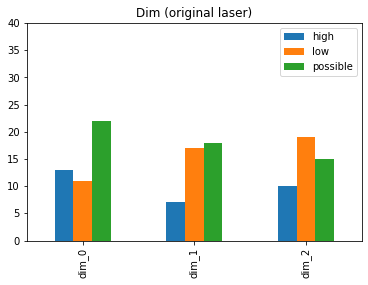

In [104]:
df_dim.plot(kind='bar')
plt.title("Dim (original laser)");
plt.ylim([0, 40])

(0.0, 40.0)

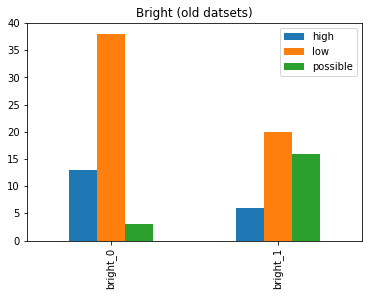

In [105]:
df_bright.plot(kind='bar')
plt.title("Bright (old datsets)");
plt.ylim([0, 40])

(0.0, 40.0)

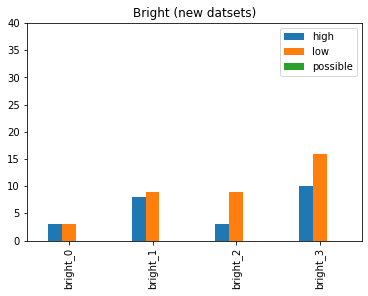

In [106]:
df_bright_new.plot(kind='bar')
plt.title("Bright (new datsets)");
plt.ylim([0, 40])

(0.0, 40.0)

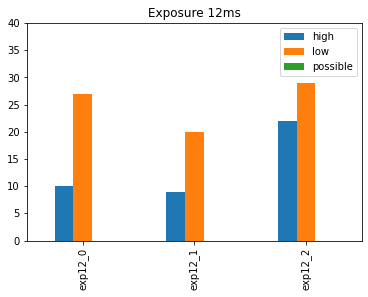

In [107]:
df_exp12.plot(kind='bar')
plt.title("Exposure 12ms");
plt.ylim([0, 40])

# Multiclass box plots

First, only include manually annotated data

In [112]:
import seaborn as sns

In [109]:
df_manual = pd.concat([df_dim, df_bright])

Text(0, 0.5, 'Number of high activity neurons')

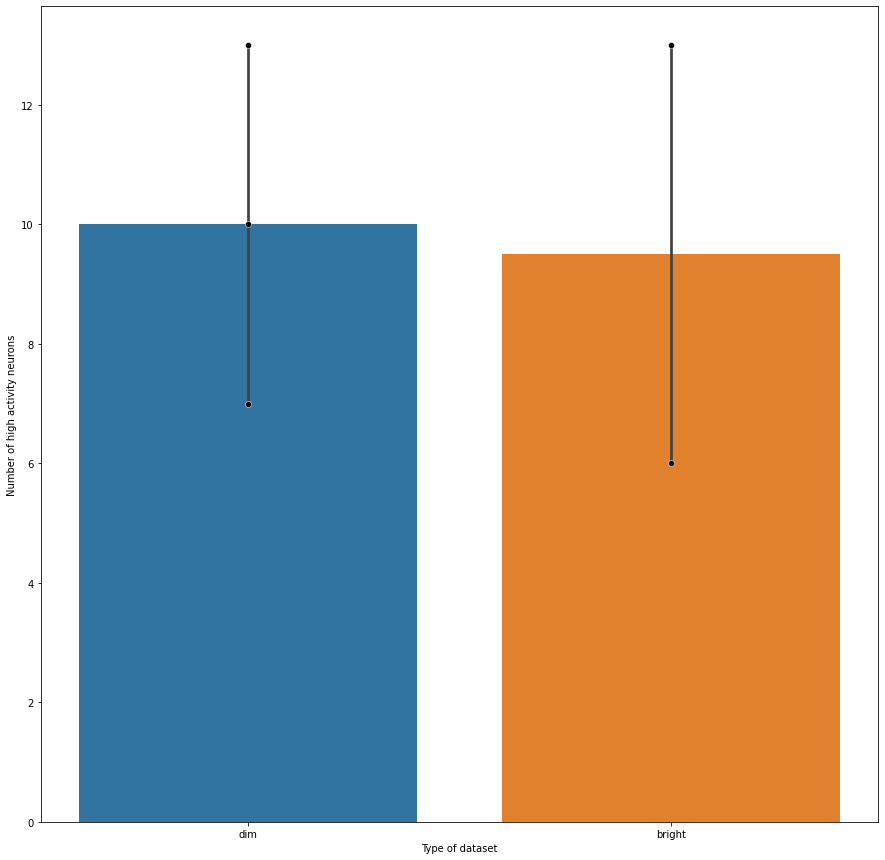

In [149]:
plt.figure(figsize=(15, 15))
to_plot = 'high'

sns.barplot(data=df_manual, y=to_plot, x='title')
sns.scatterplot(data=df_manual, y=to_plot, x='title', legend=False, zorder=10, color='k')
plt.xlabel("Type of dataset")
plt.ylabel(f"Number of {to_plot} activity neurons")

Text(0, 0.5, 'Number of low activity neurons')

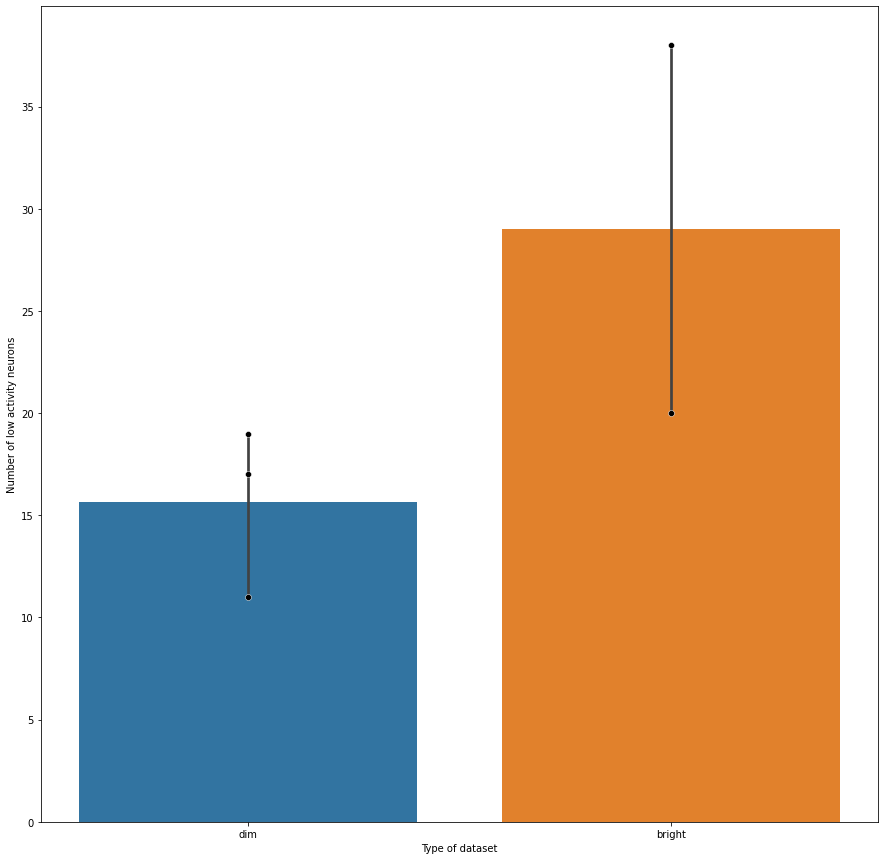

In [150]:
plt.figure(figsize=(15, 15))
to_plot = 'low'

sns.barplot(data=df_manual, y=to_plot, x='title')
sns.scatterplot(data=df_manual, y=to_plot, x='title', legend=False, zorder=10, color='k')
plt.xlabel("Type of dataset")
plt.ylabel(f"Number of {to_plot} activity neurons")

## Same, but include non manually annotated data

In [143]:
df_all = pd.concat([df_dim_all, df_bright_all, df_bright_new, df_exp12])

Text(0, 0.5, 'Number of high activity neurons')

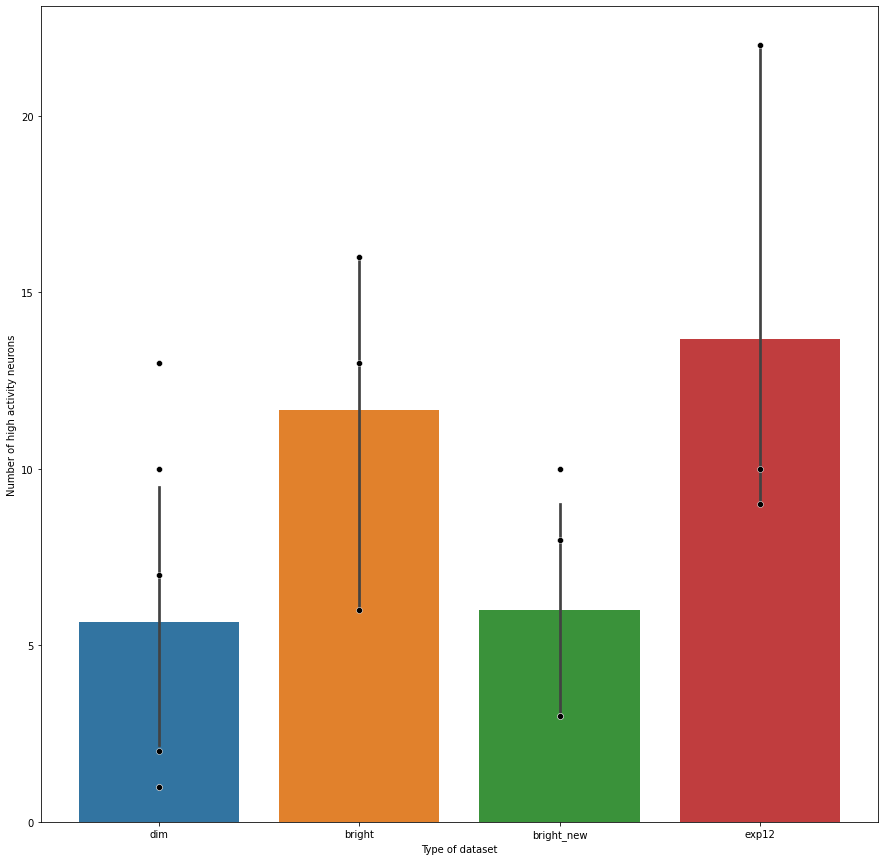

In [151]:
plt.figure(figsize=(15, 15))

to_plot = 'high'
df = df_all

sns.barplot(data=df, y=to_plot, x='title')
sns.scatterplot(data=df, y=to_plot, x='title', legend=False, zorder=10, color='k')
plt.xlabel("Type of dataset")
plt.ylabel(f"Number of {to_plot} activity neurons")

Text(0, 0.5, 'Number of low activity neurons')

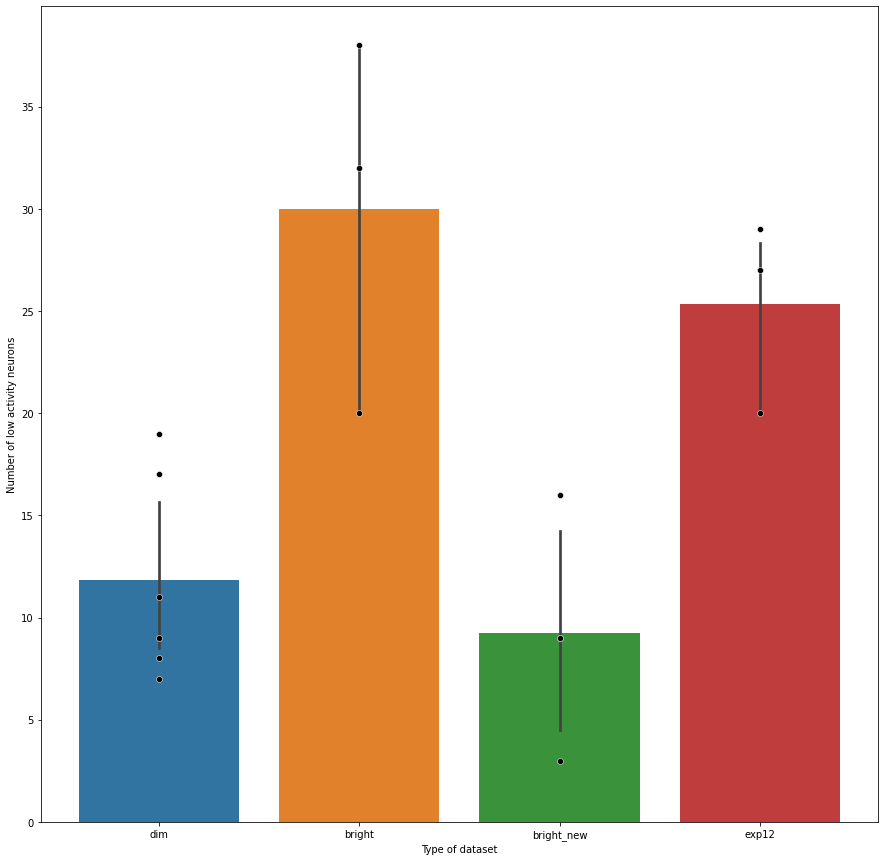

In [152]:
plt.figure(figsize=(15, 15))

to_plot = 'low'
df = df_all

sns.barplot(data=df, y=to_plot, x='title')
sns.scatterplot(data=df, y=to_plot, x='title', legend=False, zorder=10, color='k')
plt.xlabel("Type of dataset")
plt.ylabel(f"Number of {to_plot} activity neurons")